In [139]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Load the dataset

In [140]:
train_dataset, test_dataset = tfds.load("malaria", split=["train[:80%]", "train[-20%:]"], as_supervised=True, shuffle_files=True)
print(train_dataset)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Examples

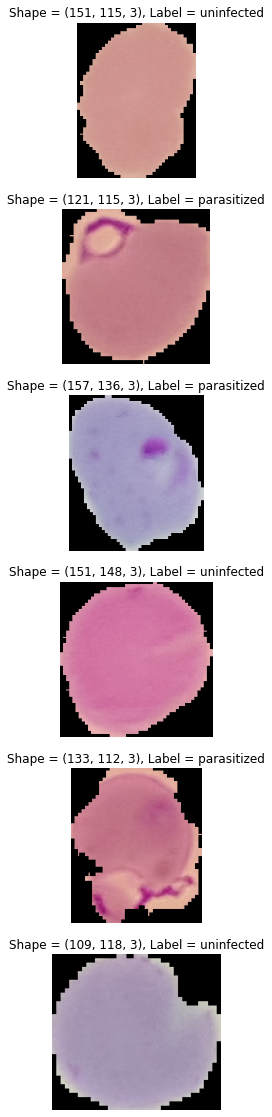

In [141]:
fig, ax = plt.subplots(6,1, figsize=(20, 20))
for i, (image, label) in enumerate(train_dataset.take(6)):
    ax[i].imshow(image)
    ax[i].set_title(f'Shape = {image.shape}, Label = {"parasitized" if label == 0 else "uninfected"}')
    ax[i].axis('off')

In [142]:
# input pipeline
#### for train_dataset

# resize the images and onehot the labels
train_dataset = train_dataset.map(lambda sample, label: (tf.image.resize_with_pad(sample, 180, 180), tf.one_hot(label, 1)))
# normalize
train_dataset = train_dataset.map(lambda sample, target: (tf.cast(sample / 255, tf.float32), target))

# batching
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(40)
train_dataset = train_dataset.shuffle(buffer_size=64)

#### for test_dataset

test_dataset = test_dataset.map(lambda sample, target: (tf.image.resize_with_pad(sample, 180, 180), tf.one_hot(label, 1)))
# normalize
test_dataset = test_dataset.map(lambda sample, target: (tf.cast(sample / 255, tf.float32), target))
test_dataset = test_dataset.batch(64)
test_dataset = test_dataset.prefetch(40)
test_dataset = test_dataset.shuffle(buffer_size=64)

In [143]:
for (img,label) in test_dataset:
    print(img.shape)
    break;

(64, 180, 180, 3)


In [144]:
#fig, ax = plt.subplots(6,1, figsize=(20, 20))
#for i, (image, label) in enumerate(train_dataset.take(6)):
#    ax[i].imshow(image)
#    #ax[i].set_title(f'Shape = {image.shape}, Label = {"parasitized" if label == [0,0] else "uninfected"}')
#    ax[i].axis('off')

Build the model

In [145]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model):
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the layers
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.keras.activations.relu, input_shape=(180,180,3))
        self.max_pool1 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.keras.activations.relu)
        self.max_pool2 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.keras.activations.relu)
        self.max_pool3 = tf.keras.layers.MaxPool2D()
        self.conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=tf.keras.activations.relu)
        self.max_pool4 = tf.keras.layers.MaxPool2D()
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
    
    @tf.function
    def call(self, x):
        # Define forward step
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = self.max_pool3(x)
        x = self.conv4(x)
        x = self.max_pool4(x)
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x
        

Train the model

In [146]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.mean(abs(target - prediction) < 0.5) #np.argmax(target, axis=1) == np.argmax(prediction, axis=1) 
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append((sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [147]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 15
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: binary cross entropy. Check out 'tf.keras.losses'.
binary_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, binary_entropy_loss)

test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, binary_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=12)
    test_dataset = test_dataset.shuffle(buffer_size=12)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, binary_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, binary_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14


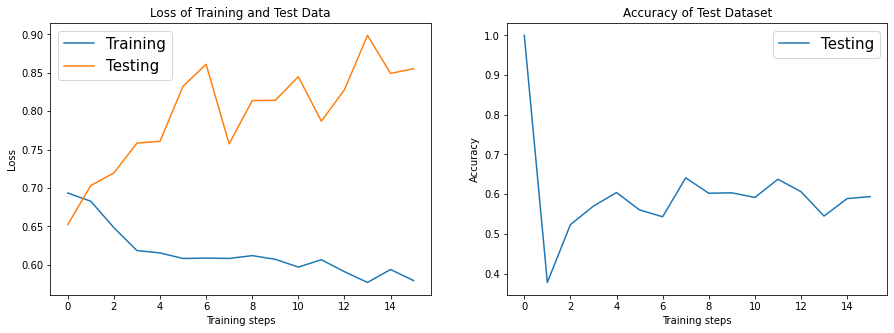

In [148]:
# Visualize accuracy and loss for training and test data

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# One plot training and test loss
axes[0].plot(train_losses, label="Training")
axes[0].plot(test_losses, label="Testing")
axes[0].set(title="Loss of Training and Test Data", xlabel="Training steps", ylabel="Loss")
axes[0].legend(fontsize=15)

# One plot training and test accuracy
axes[1].plot(test_accuracies, label="Testing")
axes[1].set(title="Accuracy of Test Dataset", xlabel="Training steps", ylabel="Accuracy")
axes[1].legend(fontsize=15)
plt.show()

In [149]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  295168